In [492]:
import os
import glob
import random
from datetime import datetime

import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 깨짐 방지

In [499]:
# 랜덤 시드 고정
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True)

In [165]:
# 데이터 가비지 헤더 제거 및 클로로필 단위 변환 함수
def load_clean_csv(path):
    with open(path, 'r', encoding='utf-8-sig') as f:
        lines = f.readlines()

    header_idx = None
    for i, line in enumerate(lines):
        if "날짜 시간" in line:
            header_idx = i
            break

    if header_idx is None:
        raise ValueError(f"'날짜 시간' 행을 찾을 수 없습니다: {path}")

    df = pd.read_csv(path, skiprows=header_idx)
    df['날짜 시간'] = pd.to_datetime(df['날짜 시간'])
    df['날짜'] = df['날짜 시간'].dt.date

    # ---- 클로로필 관련 열 자동 탐색 ----
    chl_cols = [c for c in df.columns if "Chlorophyll" in c and "농도" in c]

    for col in chl_cols:
        if "(ppb)" in col:
            # ppb → µg/L 변환
            df[col.replace("(ppb)", "(µg/L)")] = df[col]
            df.drop(columns=[col], inplace=True)
            
    return df

In [166]:
# 날짜별 요약 CSV 생성 함수
def summarize_point_folder(point_folder, save_dir):
    """하나의 포인트 폴더 내 모든 날짜 CSV를 불러와 평균 요약"""
    summary_list = []

    for date_folder in sorted(os.listdir(point_folder)):
        date_path = os.path.join(point_folder, date_folder)
        if not os.path.isdir(date_path):
            continue  # 혹시 폴더 아닌게 섞여 있을 수도 있음

        daily_dfs = []

        for file in os.listdir(date_path):
            if not file.endswith(".csv"):
                continue
            file_path = os.path.join(date_path, file)
            try:
                df = load_clean_csv(file_path)
                daily_dfs.append(df)
            except Exception as e:
                print(f"⚠️ {file_path} 로드 실패: {e}")

        if len(daily_dfs) == 0:
            continue

        # 여러 CSV를 concat 후 평균 계산
        daily_df = pd.concat(daily_dfs)
        daily_mean = daily_df.mean(numeric_only=True)
        daily_mean["날짜"] = pd.to_datetime(date_folder, format="%Y%m%d").date()

        summary_list.append(daily_mean)

    # 날짜별 평균이 담긴 DataFrame 생성
    if len(summary_list) > 0:
        summary_df = pd.DataFrame(summary_list)
        summary_df.sort_values("날짜", inplace=True)
        cols = ["날짜"] + [c for c in summary_df.columns if c != "날짜"]
        summary_df = summary_df[cols]
        
        point_name = os.path.basename(point_folder.rstrip("/\\"))
        os.makedirs(save_dir, exist_ok=True)
        save_path = os.path.join(save_dir, f"{point_name}_summary.csv")
        summary_df.to_csv(save_path, index=False, encoding='utf-8-sig')
        print(f"✅ {point_name} 요약 CSV 저장 완료 → {save_path}")
    else:
        print(f"❌ {point_folder} 요약 데이터 없음.")


In [ ]:
# # 폴더에 분산된 데이터 불러오기
# data_dir = "point_data"
# dataset = glob.glob(os.path.join(data_dir, "**", "*.csv"), recursive=True)
# print(len(dataset))
# print(dataset[0])

In [168]:
# # 샘플 데이터 로드 및 확인
# sample_path = dataset[0]
# df = load_clean_csv(sample_path)

# print("파일 경로:", sample_path)
# print("데이터 shape:", df.shape)
# print("컬럼명:", df.columns.tolist())
# # print(df.head())

In [169]:
# # 데이터셋 분할
# data_num = len(dataset)
# train_dataset, val_dataset, test_dataset = dataset[:int(data_num*0.8)], dataset[int(data_num*0.8):int(data_num*0.9)], dataset[int(data_num*0.9):]
# print(len(train_dataset), len(val_dataset), len(test_dataset))

In [170]:
# LSTM 모델 정의
class VanillaLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        """
        input_size: 입력 feature 수
        hidden_size: LSTM hidden 차원
        num_layers: LSTM 층 수
        output_size: 예측값 차원
        """
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        """
        x: [batch_size, seq_len, input_size]
        """
        out, _ = self.lstm(x)       # out: [batch, seq_len, hidden_size]
        out = out[:, -1, :]          # 마지막 시점 출력
        out = self.fc(out)           # [batch, output_size]
        return out

In [171]:
# 시계열 데이터셋 클래스
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [172]:
# # 모든 포인트 폴더 요약본 생성
# dataset_root = "point_data"      # 포인트 폴더들이 들어 있는 상위 폴더
# output_dir = "summaries"      # 요약본 저장 폴더
# os.makedirs(output_dir, exist_ok=True)

# for point_folder in sorted(os.listdir(dataset_root)):
#     full_path = os.path.join(dataset_root, point_folder)
#     if os.path.isdir(full_path):
#         summarize_point_folder(full_path, output_dir)

In [ ]:
# 일단위 시계열 데이터 생성
for i in range(1, 6):
    csv_path = "etc"
    csv_name = f"포인트{i}_통합_6_8_10_선택속성_기상병합.csv"
    df = pd.read_csv(f"{csv_path}/{csv_name}")

    # '날짜 시간' 열에서 날짜만 추출 (시간 제거)
    df["날짜"] = pd.to_datetime(df["날짜 시간"]).dt.date

    # 1️⃣ 같은 날짜 평균내기
    df_avg = df.groupby("날짜").mean(numeric_only=True).reset_index()

    # 2️⃣ 같은 날짜 첫 번째 행만 남기기
    df_first = df.groupby("날짜").first().reset_index()

    # CSV 저장
    df_avg.to_csv(f"data/avg_{csv_name}", index=False, encoding='utf-8-sig')
    df_first.to_csv(f"data/fst_{csv_name}", index=False, encoding='utf-8-sig')

print("Done")

Done


In [384]:
# 데이터 불러오기
file_path = "data"
file_name = "fst_포인트5_통합_6_8_10_기상병합"
df = pd.read_csv(f"{file_path}/{file_name}.csv")

# 날짜 제거 (index로 쓰거나 feature에서 제외)
df['날짜'] = pd.to_datetime(df['날짜'])
df = df.sort_values('날짜')
try:
    features = df.drop(columns=['날짜', '날짜 시간', 'TM']).values
except:
    features = df.drop(columns=['날짜', 'TM']).values
print("Features shape:", features.shape)
print("First 3 rows:\n", features[:3])

Features shape: (37, 33)
First 3 rows:
 [[ 1.07897560e+00  1.21508720e+00  0.00000000e+00  9.26803060e+05
   9.98380700e-01  7.89807000e-04  7.49845030e+00 -1.90266360e+01
   2.09098790e+02  1.91351740e+01  7.39657830e+00  5.40005060e+00
   4.99545150e+00  3.83974770e+00  4.20314520e+01  5.61988680e+01
   3.26701160e+00  3.26701160e+01  1.72798300e+01  1.00407965e+03
   2.46604820e+01  3.66869898e+01  1.28809965e+02 -9.00000000e+00
  -9.00000000e+00 -9.00000000e+00 -9.00000000e+00 -9.00000000e+00
  -9.00000000e+00 -9.00000000e+00  3.36000000e+00  0.00000000e+00
   2.10000000e+00]
 [ 6.46997030e-01  6.45614200e-01  0.00000000e+00  1.52382120e+06
   9.97046050e-01  4.27540000e-04  7.40209600e+00 -1.38720020e+01
   2.02159100e+02  2.51123330e+01  6.82030500e+00  5.00000900e+00
   4.59323930e+00  3.26563260e+00  4.01558720e+01  5.28333240e+01
   3.27712080e+00  3.27712100e+01  1.72643090e+01  1.00089810e+03
   2.75361770e+01  3.66868773e+01  1.28810173e+02 -9.00000000e+00
  -9.00000000e+00

In [ ]:
# 정규화
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)

# Chlorophyll-a 농도 컬럼 인덱스 (features 기준)
chl_flu_idx = 16
chl_conc_idx = 17

# 시퀀스 생성
seq_len = 5
X, y = [], []
for i in range(len(scaled_features) - seq_len):
    X.append(scaled_features[i:i+seq_len])
    next_day = scaled_features[i + seq_len]
    y.append(next_day[[chl_flu_idx, chl_conc_idx]])  # 두 값 예측

X, y = np.array(X), np.array(y)
print("X shape:", X.shape, "y shape:", y.shape)

# 데이터셋 분할
train_size = int(len(X) * 0.8)
val_size = int(len(X) * 0.1)
test_size = len(X) - train_size - val_size

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]
print(f"Train size: {len(X_train)}, Val size: {len(X_val)}, Test size: {len(X_test)}")
print(X_train[0], y_train[0])

# 데이터로더 생성
train_loader = DataLoader(TimeSeriesDataset(X_train, y_train), batch_size=8, shuffle=True)
val_loader = DataLoader(TimeSeriesDataset(X_val, y_val), batch_size=8, shuffle=False)
test_loader = DataLoader(TimeSeriesDataset(X_test, y_test), batch_size=8, shuffle=False)
print(f"train_loader batches: {len(train_loader)}, val_loader batches: {len(val_loader)}, test_loader batches: {len(test_loader)}")

X shape: (32, 5, 33) y shape: (32, 2)
Train size: 25, Val size: 3, Test size: 4
[[5.62411115e-03 7.05392100e-03 0.00000000e+00 5.06513524e-02
  9.79557944e-01 7.05084536e-03 3.83307365e-01 5.05477904e-01
  1.00000000e+00 3.12053998e-02 1.00000000e+00 1.00000000e+00
  1.00000000e+00 3.08725146e-01 2.43963601e-01 2.48206735e-01
  3.65996409e-02 2.71130860e-01 1.00000000e+00 1.00000000e+00
  9.35200697e-02 4.27989831e-01 5.48918739e-01 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 9.32692308e-01 0.00000000e+00
  3.93939394e-01]
 [3.37244254e-03 3.74797098e-03 0.00000000e+00 8.34639444e-02
  7.78058760e-01 3.81677856e-03 3.61550040e-01 5.24679101e-01
  9.87510673e-01 2.97854772e-01 8.54684963e-01 8.57019069e-01
  8.58513542e-01 2.62564882e-01 2.33077152e-01 2.33514880e-01
  3.67135749e-02 2.71974902e-01 7.77731634e-01 8.28955454e-01
  1.86237225e-01 3.77993387e-01 7.47165857e-01 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.

In [386]:
# 모델 정의
input_size = X_train.shape[2]
hidden_size = 64
num_layers = 3  # 1: Vanilla LSTM, 2>: Stacked LSTM
output_size = 2
model = VanillaLSTM(input_size, hidden_size, num_layers, output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [387]:
# 모델 학습
num_epochs = 300
best_train_loss = float('inf')
best_val_loss = float('inf')
best_epoch = 0
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # 검증
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_val, y_val in val_loader:
            preds = model(X_val)
            val_loss += criterion(preds, y_val).item()

    print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {total_loss/len(train_loader):.6f} | Val Loss: {val_loss/len(val_loader):.6f}")\
    
    if val_loss < best_val_loss:
        best_train_loss = total_loss/len(train_loader)
        best_val_loss = val_loss
        best_model_state = model.state_dict().copy()
        best_epoch = epoch + 1

model.load_state_dict(best_model_state)
print(f"✅ {best_epoch} model loaded with Val Loss: {best_val_loss:.6f}")

time_str = datetime.now().strftime("%Y%m%d_%H%M%S")
weight_dir = "weights"
weight_name = f"{time_str}_{file_name}_{best_epoch}epoch.pth"
torch.save(model.state_dict(), f"{weight_dir}/{weight_name}")
print(f"Saved: {weight_dir}/{weight_name}")

Epoch [1/300] Train Loss: 0.238711 | Val Loss: 0.013485
Epoch [2/300] Train Loss: 0.132389 | Val Loss: 0.006915
Epoch [3/300] Train Loss: 0.120088 | Val Loss: 0.006568
Epoch [4/300] Train Loss: 0.118065 | Val Loss: 0.011913
Epoch [5/300] Train Loss: 0.135426 | Val Loss: 0.018129
Epoch [6/300] Train Loss: 0.107839 | Val Loss: 0.027446
Epoch [7/300] Train Loss: 0.105731 | Val Loss: 0.023755
Epoch [8/300] Train Loss: 0.096401 | Val Loss: 0.013526
Epoch [9/300] Train Loss: 0.153857 | Val Loss: 0.011536
Epoch [10/300] Train Loss: 0.115696 | Val Loss: 0.025898
Epoch [11/300] Train Loss: 0.104370 | Val Loss: 0.042602
Epoch [12/300] Train Loss: 0.125825 | Val Loss: 0.015571
Epoch [13/300] Train Loss: 0.053872 | Val Loss: 0.010393
Epoch [14/300] Train Loss: 0.037589 | Val Loss: 0.008410
Epoch [15/300] Train Loss: 0.026881 | Val Loss: 0.011470
Epoch [16/300] Train Loss: 0.023090 | Val Loss: 0.014695
Epoch [17/300] Train Loss: 0.018553 | Val Loss: 0.017918
Epoch [18/300] Train Loss: 0.046159 | Va

MSE per feature → Chl_flu: 0.000383, Chl_nong: 0.017452

=== 마지막 입력 및 예측 결과 ===
입력 시퀀스 (마지막 샘플):
[[2.8639860e-04 2.4434336e-04 0.0000000e+00 1.0000000e+00 0.0000000e+00
  2.4460806e-04 7.4494529e-01 2.4325286e-01 6.1104071e-01 1.0000000e+00
  5.8955455e-01 5.3655720e-01 5.8264810e-01 5.3464091e-01 6.2833881e-01
  6.0879004e-01 2.1139098e-02 1.5659887e-01 2.5533438e-01 1.3890114e-01
  8.3092737e-01 0.0000000e+00 9.6503764e-02 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  8.4615386e-01 6.0000002e-01 3.0303031e-01]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 5.4932147e-01 2.8701159e-01
  0.0000000e+00 4.6746612e-01 5.2938104e-01 5.4982352e-01 7.7016389e-01
  7.5125635e-01 7.5688940e-01 7.5620764e-01 1.0021014e-01 1.0810825e-01
  1.0955067e-01 2.2604620e-02 1.6745548e-01 3.2772449e-01 1.7960389e-01
  7.9681259e-01 4.7686625e-01 6.4342195e-01 0.0000000e+00 0.0000000e+00
  0.0000000e+00 1.0000000e+00 0.0000000e+00 0.0000000e+00 0.000000

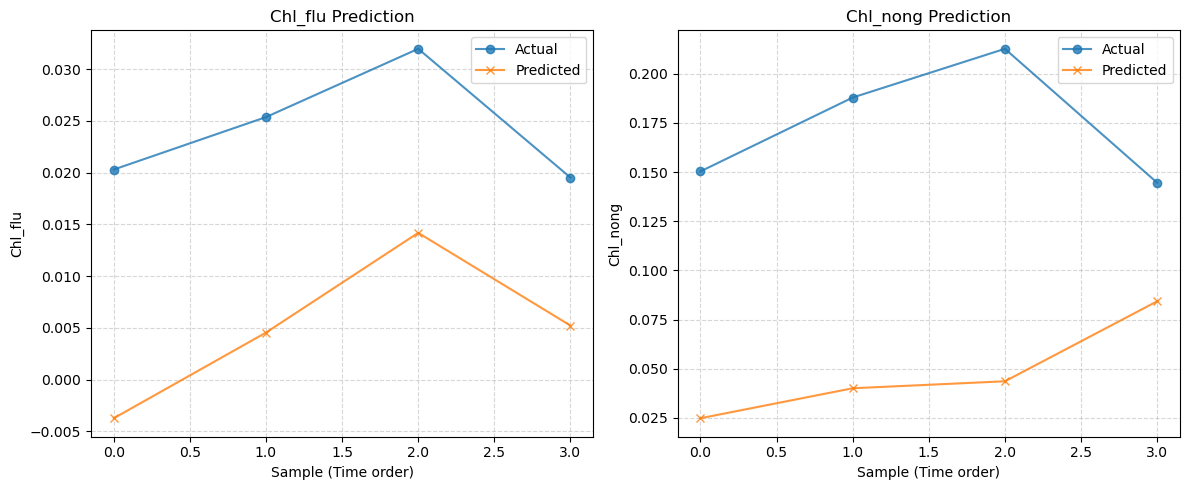

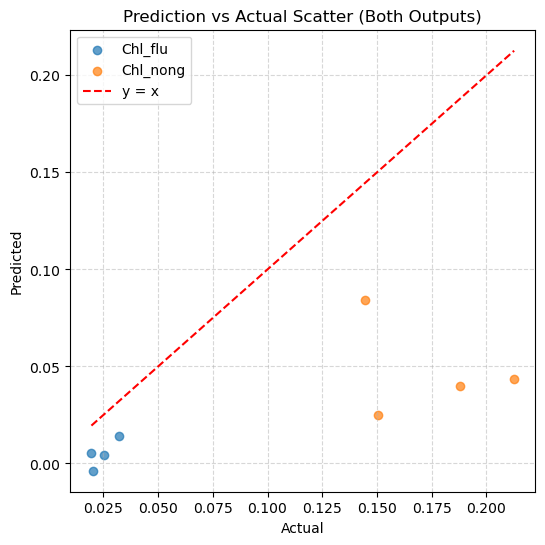

In [ ]:
# 테스트 및 평가
model.eval()
all_preds = []
all_labels = []
test_loss = 0

with torch.no_grad():
    for X_test, y_test in test_loader:
        X_test = X_test.float()
        y_test = y_test.float()

        y_preds = model(X_test)
        all_preds.append(y_preds.cpu())
        all_labels.append(y_test.cpu())
        test_loss += criterion(y_preds, y_test).item()

y_pred = torch.cat(all_preds, dim=0).numpy()
y_true = torch.cat(all_labels, dim=0).numpy()

mse_each = ((y_pred - y_true) ** 2).mean(axis=0)
print(f"MSE per feature → Chl_flu: {mse_each[0]:.6f}, Chl_conc: {mse_each[1]:.6f}")

print("\n=== 마지막 입력 및 예측 결과 ===")
print(f"입력 시퀀스 (마지막 샘플):\n{X_test[-1].numpy()}")
print(f"실제값 (y_true): {y_true[-1]}")
print(f"예측값 (y_pred): {y_pred[-1]}")

# Visualization
feature_names = ["Chl_flu", "Chl_conc"]
plt.figure(figsize=(12, 5))

for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.plot(y_true[:, i], label="Actual", marker='o', alpha=0.8)
    plt.plot(y_pred[:, i], label="Predicted", marker='x', alpha=0.8)
    plt.title(f"{feature_names[i]} Prediction")
    plt.xlabel("Sample (Time order)")
    plt.ylabel(feature_names[i])
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

# Scatter comparison
plt.figure(figsize=(6,6))
for i in range(2):
    plt.scatter(y_true[:, i], y_pred[:, i], label=feature_names[i], alpha=0.7)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', label="y = x")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.legend()
plt.title("Prediction vs Actual Scatter (Both Outputs)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


In [ ]:
# 마지막 샘플 실제값과 예측값 복원
feature_indices = [chl_flu_idx, chl_conc_idx]

dummy_true = np.zeros(scaled_features.shape[1])
dummy_pred = np.zeros(scaled_features.shape[1])
dummy_true[feature_indices] = y_true[-1]  # 스케일된 마지막 실제값
dummy_pred[feature_indices] = y_pred[-1]  # 스케일된 마지막 예측값

# 역변환
y_true_orig = scaler.inverse_transform(dummy_true.reshape(1, -1))[0, feature_indices]
y_pred_orig = scaler.inverse_transform(dummy_pred.reshape(1, -1))[0, feature_indices]
print("\n=== 마지막 입력 및 예측 결과 (원래 단위) ===")
print(f"실제값 (원래 단위): {y_true_orig}")
print(f"예측값 (원래 단위): {y_pred_orig}")


=== 마지막 입력 및 예측 결과 (원래 단위) ===
실제값 (원래 단위): [ 1.75150784 17.51507747]
예측값 (원래 단위): [ 0.48257094 10.29414484]


In [ ]:
# 결과 로그 저장
log_dict = {
    "datetime": time_str,
    "file_name": file_name,
    "best_epoch": best_epoch,
    "train_loss": best_train_loss,
    "val_loss": best_val_loss,
    "test_loss": test_loss,
    "test_mse": np.mean(mse_each),
    "hidden_size": hidden_size,
    "num_layers": num_layers
}
with open('weights/weights_result.csv', mode='a', newline='', encoding='utf-8') as f:
    df_new = pd.DataFrame([log_dict])
    df_new.to_csv('weights/weights_result.csv', mode='a', index=False, header=False, encoding='utf-8')

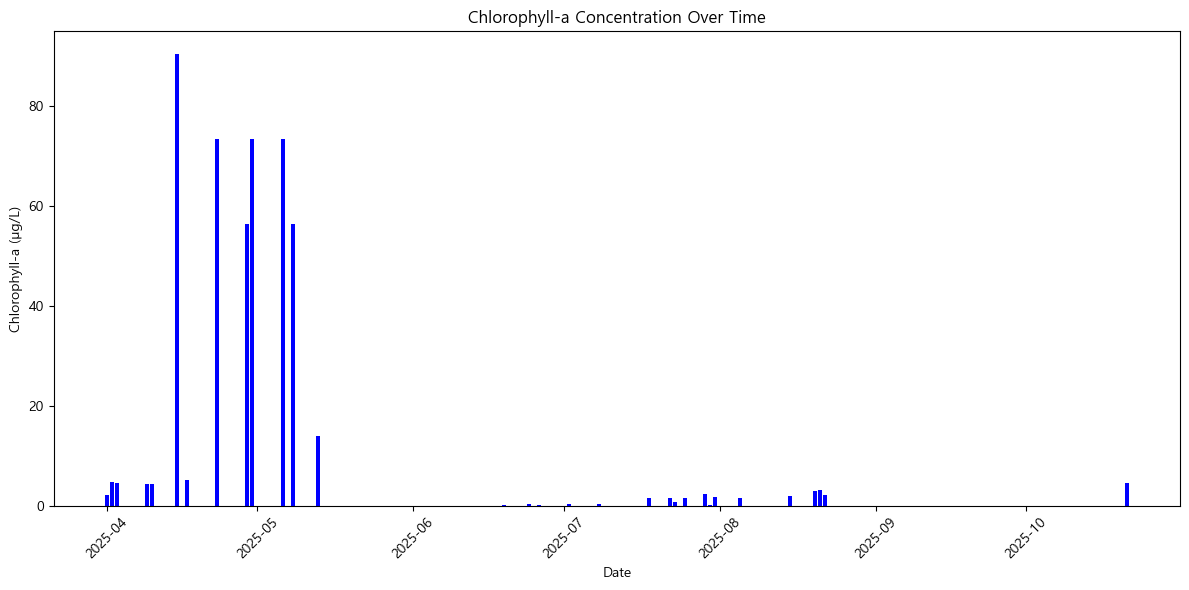

In [475]:
file_name = "avg_포인트1_통합_6_8_10_기상병합"
df = pd.read_csv(f"data/{file_name}.csv")

# 날짜 컬럼을 datetime으로 변환
df['날짜'] = pd.to_datetime(df['날짜'])

# 날짜 순으로 정렬
df = df.sort_values('날짜')

# 전체 날짜 범위 생성 (비어 있는 날짜 포함)
full_range = pd.date_range(start=df['날짜'].min(), end=df['날짜'].max())

# 전체 날짜 기준으로 reindex
df_full = df.set_index('날짜').reindex(full_range)

# 열 이름 복구
df_full.index.name = '날짜'

# 클로로필 컬럼 이름 맞추기
chlorophyll_col = [col for col in df.columns if 'Chlorophyll' in col][0]

# 그래프 그리기
plt.figure(figsize=(12, 6))
plt.bar(df_full.index, df_full[chlorophyll_col], color='blue')

plt.title("Chlorophyll-a Concentration Over Time")
plt.xlabel("Date")
plt.ylabel("Chlorophyll-a (µg/L)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

✅ 'data_interpolated.csv' 파일이 생성되었습니다.


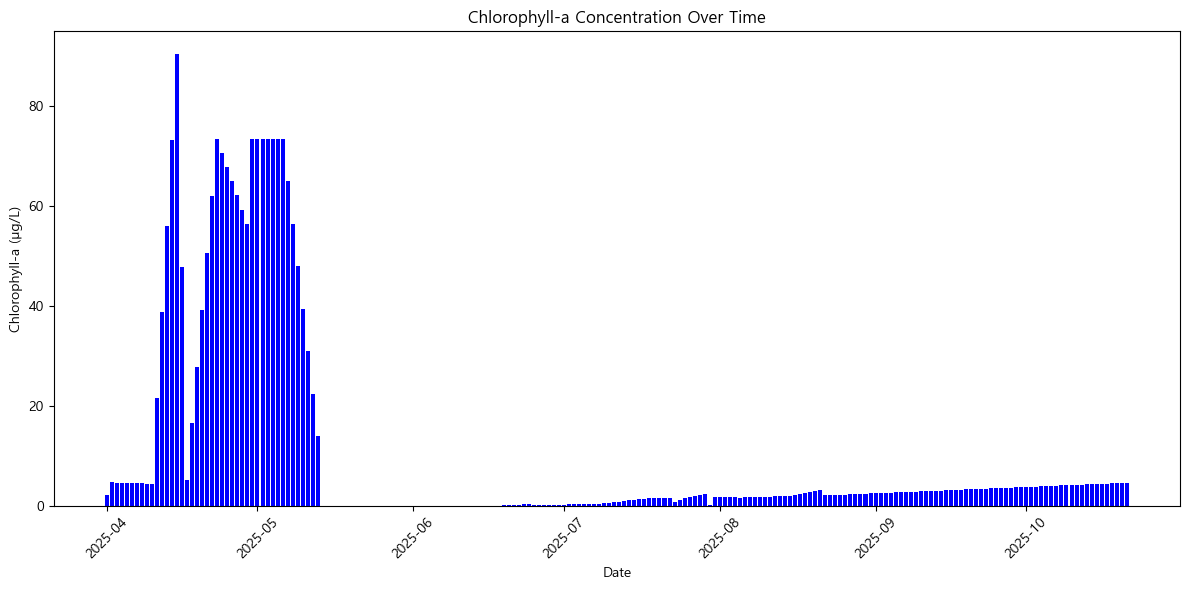

In [476]:
df = pd.read_csv(f"data/{file_name}.csv")

df['날짜'] = pd.to_datetime(df['날짜'])
df = df.sort_values('날짜')

full_range = pd.date_range(start=df['날짜'].min(), end=df['날짜'].max(), freq='D')
df_full = df.set_index('날짜').reindex(full_range)

df_full.index.name = '날짜'
df_full = df_full.interpolate(method='linear')

# 8️⃣ 보간 후 남은 결측치가 있다면 그대로 둠(또는 필요 시 fillna)
# df_full = df_full.fillna(0)  # 필요시 활성화

df_full.to_csv("data/data_interpolated.csv", index=True, encoding='utf-8-sig')
print("✅ 'data_interpolated.csv' 파일이 생성되었습니다.")

df = pd.read_csv("data/data_interpolated.csv")

# 날짜 컬럼을 datetime으로 변환
df['날짜'] = pd.to_datetime(df['날짜'])

# 날짜 순으로 정렬
df = df.sort_values('날짜')

# 전체 날짜 범위 생성 (비어 있는 날짜 포함)
full_range = pd.date_range(start=df['날짜'].min(), end=df['날짜'].max())

# 전체 날짜 기준으로 reindex
df_full = df.set_index('날짜').reindex(full_range)

# 열 이름 복구
df_full.index.name = '날짜'

# 클로로필 컬럼 이름 맞추기
chlorophyll_col = [col for col in df.columns if 'Chlorophyll' in col][0]

# 그래프 그리기
plt.figure(figsize=(12, 6))
plt.bar(df_full.index, df_full[chlorophyll_col], color='blue')

plt.title("Chlorophyll-a Concentration Over Time")
plt.xlabel("Date")
plt.ylabel("Chlorophyll-a (µg/L)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

✅ 'data_interpolated.csv' 파일이 생성되었습니다.
Features shape: (204, 33)
First rows:
 [ 0.00000000e+00  0.00000000e+00  8.58248500e-11  1.00000000e+07
  9.97343286e-01  0.00000000e+00  4.43021095e+00  1.56105502e+02
  3.14902879e+02  2.38217745e+01  4.40077549e+00  3.28551665e+00
  2.90175091e+00  8.67831755e+00  1.03423877e+02  1.37671010e+02
  2.23260129e+00  2.23969047e+01  1.71265874e+01  1.00683555e+03
  2.76959071e+01  3.66920010e+01  1.28809689e+02 -9.00000000e+00
 -9.00000000e+00 -9.00000000e+00 -9.00000000e+00 -9.00000000e+00
 -9.00000000e+00 -9.00000000e+00  2.26000000e+00  2.00000000e+00
  1.10000000e+00]
X shape: (199, 5, 33) y shape: (199, 2)
Train size: 159, Val size: 19, Test size: 21
[[0.00000000e+00 0.00000000e+00 5.52285831e-07 5.35735487e-01
  6.04272002e-01 0.00000000e+00 0.00000000e+00 1.00000000e+00
  1.00000000e+00 4.85202155e-01 2.47156538e-01 2.78686298e-01
  5.31114361e-02 4.81150811e-02 7.84270025e-01 7.88510113e-01
  2.44822633e-02 1.79223074e-01 0.00000000e+00 8.43

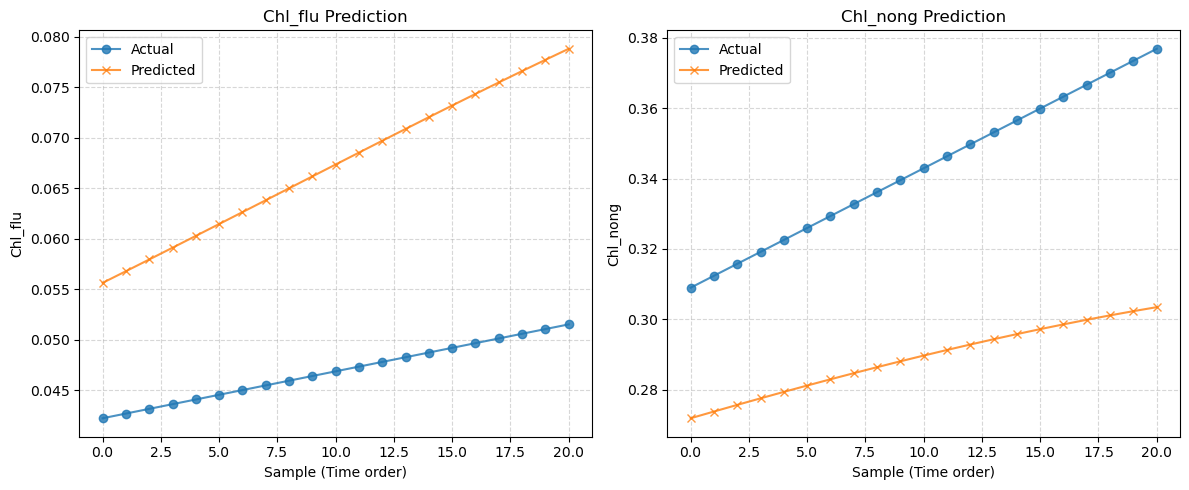

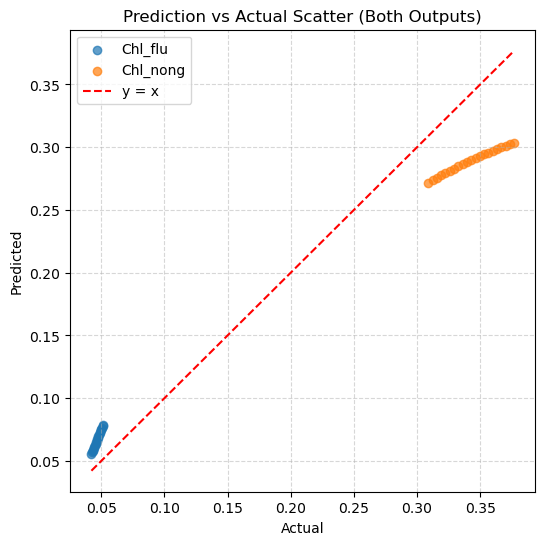


=== 마지막 입력 및 예측 결과 (원래 단위) ===
실제값 (원래 단위): [ 4.67485819 46.87620962]
예측값 (원래 단위): [ 7.14270857 37.77683543]


In [ ]:
file_name = "avg_포인트1_통합_6_8_10_기상병합"
df = pd.read_csv(f"data/{file_name}.csv")

df['날짜'] = pd.to_datetime(df['날짜'])
df = df.sort_values('날짜')

full_range = pd.date_range(start=df['날짜'].min(), end=df['날짜'].max(), freq='D')
df_full = df.set_index('날짜').reindex(full_range)

df_full.index.name = '날짜'
df_full = df_full.interpolate(method='linear')

df_full.to_csv("data/data_interpolated.csv", index=True, encoding='utf-8-sig')
print("✅ 'data_interpolated.csv' 파일이 생성되었습니다.")

df_full = df_full.sort_values('날짜')
try:
    features = df_full.drop(columns=['날짜 시간', 'TM']).values
except:
    features = df_full.drop(columns=['TM']).values
print("Features shape:", features.shape)
print("First rows:\n", features[0])

# 정규화
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)

# Chlorophyll-a 농도 컬럼 인덱스 (features 기준)
chl_flu_idx = 16
chl_conc_idx = 17

# 시퀀스 생성
seq_len = 5
X, y = [], []
for i in range(len(scaled_features) - seq_len):
    X.append(scaled_features[i:i+seq_len])
    next_day = scaled_features[i + seq_len]
    y.append(next_day[[chl_flu_idx, chl_conc_idx]])  # 두 값 예측

X, y = np.array(X), np.array(y)
print("X shape:", X.shape, "y shape:", y.shape)

# 데이터셋 분할
train_size = int(len(X) * 0.8)
val_size = int(len(X) * 0.1)
test_size = len(X) - train_size - val_size

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]
print(f"Train size: {len(X_train)}, Val size: {len(X_val)}, Test size: {len(X_test)}")
print(X_train[0], y_train[0])

# 데이터로더 생성
train_loader = DataLoader(TimeSeriesDataset(X_train, y_train), batch_size=8, shuffle=True)
val_loader = DataLoader(TimeSeriesDataset(X_val, y_val), batch_size=8, shuffle=False)
test_loader = DataLoader(TimeSeriesDataset(X_test, y_test), batch_size=8, shuffle=False)
print(f"train_loader batches: {len(train_loader)}, val_loader batches: {len(val_loader)}, test_loader batches: {len(test_loader)}")

# 모델 정의
input_size = X_train.shape[2]
hidden_size = 64
num_layers = 2  # 1: Vanilla LSTM, 2>: Stacked LSTM
output_size = 2
model = VanillaLSTM(input_size, hidden_size, num_layers, output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 모델 학습
num_epochs = 300
best_train_loss = float('inf')
best_val_loss = float('inf')
best_epoch = 0
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # 검증
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_val, y_val in val_loader:
            preds = model(X_val)
            val_loss += criterion(preds, y_val).item()

    print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {total_loss/len(train_loader):.6f} | Val Loss: {val_loss/len(val_loader):.6f}")\
    
    if val_loss < best_val_loss:
        best_train_loss = total_loss/len(train_loader)
        best_val_loss = val_loss
        best_model_state = model.state_dict().copy()
        best_epoch = epoch + 1

model.load_state_dict(best_model_state)
print(f"✅ {best_epoch} model loaded with Val Loss: {best_val_loss:.6f}")

time_str = datetime.now().strftime("%Y%m%d_%H%M%S")
weight_dir = "weights"
weight_name = f"{time_str}_{file_name}_{best_epoch}epoch.pth"
torch.save(model.state_dict(), f"{weight_dir}/{weight_name}")
print(f"Saved: {weight_dir}/{weight_name}")

# 테스트 및 평가
model.eval()
all_preds = []
all_labels = []
test_loss = 0

with torch.no_grad():
    for X_test, y_test in test_loader:
        X_test = X_test.float()
        y_test = y_test.float()

        y_preds = model(X_test)
        loss = criterion(y_preds, y_test).item()
        batch_size = X_test.size(0)
        test_loss += loss * batch_size
        total_samples += batch_size

        all_preds.append(y_preds.cpu())
        all_labels.append(y_test.cpu())

test_loss /= total_samples
y_pred = torch.cat(all_preds, dim=0).numpy()
y_true = torch.cat(all_labels, dim=0).numpy()

mse_each = ((y_pred - y_true) ** 2).mean(axis=0)
print(f"MSE per feature → Chl_flu: {mse_each[0]:.6f}, Chl_conc: {mse_each[1]:.6f}")

print("\n=== 마지막 입력 및 예측 결과 ===")
print(f"입력 시퀀스 (마지막 샘플):\n{X_test[-1].numpy()}")
print(f"실제값 (y_true): {y_true[-1]}")
print(f"예측값 (y_pred): {y_pred[-1]}")

# Visualization
feature_names = ["Chl_flu", "Chl_conc"]
plt.figure(figsize=(12, 5))

for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.plot(y_true[:, i], label="Actual", marker='o', alpha=0.8)
    plt.plot(y_pred[:, i], label="Predicted", marker='x', alpha=0.8)
    plt.title(f"{feature_names[i]} Prediction")
    plt.xlabel("Sample (Time order)")
    plt.ylabel(feature_names[i])
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

# Scatter comparison
plt.figure(figsize=(6,6))
for i in range(2):
    plt.scatter(y_true[:, i], y_pred[:, i], label=feature_names[i], alpha=0.7)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', label="y = x")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.legend()
plt.title("Prediction vs Actual Scatter (Both Outputs)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

# 마지막 샘플 실제값과 예측값 복원
feature_indices = [chl_flu_idx, chl_conc_idx]

dummy_true = np.zeros(scaled_features.shape[1])
dummy_pred = np.zeros(scaled_features.shape[1])
dummy_true[feature_indices] = y_true[-1]  # 스케일된 마지막 실제값
dummy_pred[feature_indices] = y_pred[-1]  # 스케일된 마지막 예측값

# 역변환
y_true_orig = scaler.inverse_transform(dummy_true.reshape(1, -1))[0, feature_indices]
y_pred_orig = scaler.inverse_transform(dummy_pred.reshape(1, -1))[0, feature_indices]
print("\n=== 마지막 입력 및 예측 결과 (원래 단위) ===")
print(f"실제값 (원래 단위): {y_true_orig}")
print(f"예측값 (원래 단위): {y_pred_orig}")

# 결과 로그 저장
log_dict = {
    "datetime": time_str,
    "file_name": file_name,
    "best_epoch": best_epoch,
    "train_loss": best_train_loss,
    "val_loss": best_val_loss,
    "test_loss": test_loss,
    "test_mse": np.mean(mse_each),
    "hidden_size": hidden_size,
    "num_layers": num_layers
}
with open('weights/weights_result.csv', mode='a', newline='', encoding='utf-8') as f:
    df_new = pd.DataFrame([log_dict])
    df_new.to_csv('weights/weights_result.csv', mode='a', index=False, header=False, encoding='utf-8')
    

In [455]:
result_df = pd.read_csv("weights/weights_result.csv")

# datetime 정리
result_df['datetime'] = pd.to_datetime(result_df['datetime'], format='%Y%m%d_%H%M%S')

# test_mse가 비어있는 부분 확인
print(result_df['test_mse'].isna().sum())

result_df['test_mse'] = result_df['test_mse'].fillna(result_df['test_loss']**2)

36


In [457]:
# 기술 통계
print(result_df.describe())

# 손실 간 상관관계
print(result_df[['train_loss','val_loss','test_loss','test_mse']].corr())


                            datetime  best_epoch  train_loss   val_loss  \
count                             60   60.000000   60.000000  60.000000   
mean   2025-10-31 20:30:36.083333376  128.500000    0.030005   0.002575   
min              2025-10-31 15:47:43    1.000000    0.000010   0.000021   
25%    2025-10-31 17:38:27.249999872   15.250000    0.000314   0.000333   
50%              2025-10-31 17:52:16  100.000000    0.001016   0.001366   
75%    2025-11-01 01:24:07.750000128  249.500000    0.052136   0.003116   
max              2025-11-01 01:36:17  300.000000    0.247774   0.012930   
std                              NaN  115.856647    0.052824   0.003174   

       test_loss   test_mse  hidden_size  num_layers  
count  60.000000  60.000000         60.0   60.000000  
mean    0.029449   0.004611         64.0    1.800000  
min     0.000714   0.000013         64.0    1.000000  
25%     0.004630   0.000193         64.0    1.000000  
50%     0.011156   0.001075         64.0    2.000

In [461]:
# file_name별 평균 성능
summary = result_df.groupby('file_name')[['val_loss','test_loss','test_mse']].mean().sort_values('test_mse')
print(summary)


                           val_loss  test_loss  test_mse
file_name                                               
fst_포인트2_통합_6_8_10_기상병합    0.000756   0.004600  0.000278
avg_포인트3_통합_6_8_10_기상병합    0.002546   0.008876  0.000317
avg_포인트2_통합_6_8_10_기상병합    0.001578   0.008671  0.000395
fst_포인트3_통합_6_8_10_기상병합    0.000824   0.009524  0.000500
fst_포인트4_통합_6_8_10_기상병합    0.007029   0.009504  0.000843
fst_포인트5_통합_6_8_10_기상병합    0.007024   0.011567  0.001151
avg_포인트1_통합_6_8_10_기상병합    0.000782   0.018581  0.001596
avg_포인트5_통합_6_8_10_기상병합    0.003507   0.011756  0.003564
avg_포인트4_통합_6_8_10_기상병합    0.003598   0.053705  0.005807
avg_포인트1_통합_8_10(정제)_기상병합  0.000641   0.066226  0.008819
fst_포인트1_통합_8_10(정제)_기상병합  0.001444   0.067309  0.010051
fst_포인트1_통합_6_8_10_기상병합    0.001175   0.083065  0.022007


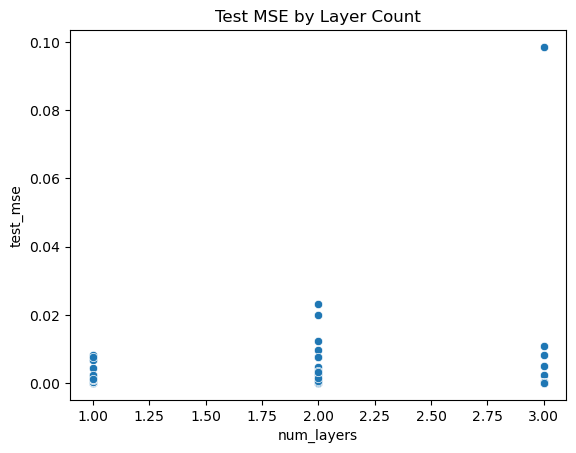

In [465]:
sns.scatterplot(data=result_df, x='num_layers', y='test_mse')
plt.title("Test MSE by Layer Count")
plt.show()

In [467]:
# test_mse 기준 성능 랭킹
ranking = result_df.sort_values('test_mse').head(10)
print(ranking[['datetime','file_name','test_mse','val_loss','hidden_size','num_layers']])


              datetime                file_name  test_mse  val_loss  \
29 2025-10-31 17:51:36  fst_포인트5_통합_6_8_10_기상병합  0.000013  0.005157   
26 2025-10-31 17:49:38  fst_포인트2_통합_6_8_10_기상병합  0.000013  0.000700   
20 2025-10-31 17:46:58  fst_포인트2_통합_6_8_10_기상병합  0.000017  0.002327   
1  2025-10-31 15:49:50  avg_포인트1_통합_6_8_10_기상병합  0.000019  0.001222   
11 2025-10-31 17:07:01  avg_포인트5_통합_6_8_10_기상병합  0.000035  0.002036   
17 2025-10-31 17:39:31  avg_포인트5_통합_6_8_10_기상병합  0.000050  0.001975   
33 2025-10-31 17:54:30  fst_포인트3_통합_6_8_10_기상병합  0.000055  0.000468   
22 2025-10-31 17:47:44  fst_포인트4_통합_6_8_10_기상병합  0.000072  0.007658   
35 2025-10-31 17:55:19  fst_포인트5_통합_6_8_10_기상병합  0.000080  0.005167   
3  2025-10-31 15:50:36  avg_포인트3_통합_6_8_10_기상병합  0.000096  0.002099   

    hidden_size  num_layers  
29           64           2  
26           64           2  
20           64           1  
1            64           2  
11           64           1  
17           64           3  
33      

group
avg    0.003416
fst    0.005805
Name: test_mse, dtype: float64


C:\Users\ty\AppData\Local\Temp\ipykernel_133560\447941622.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=result_df, x='group', y='test_mse', palette='Set2')


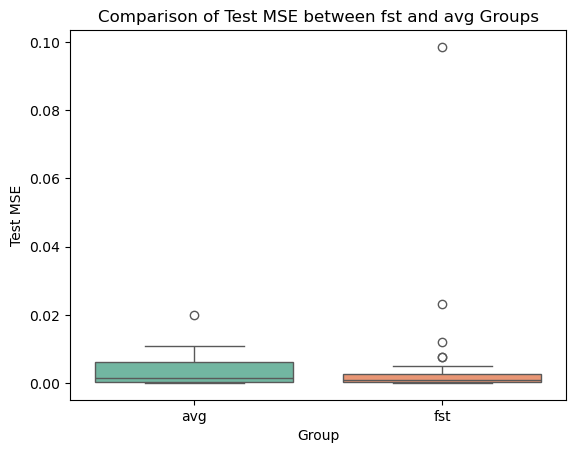

In [469]:
# fst / avg 그룹 구분 컬럼 추가
result_df['group'] = result_df['file_name'].apply(lambda x: 'fst' if str(x).startswith('fst') else ('avg' if str(x).startswith('avg') else 'other'))
print(result_df.groupby('group')['test_mse'].mean())

sns.boxplot(data=result_df, x='group', y='test_mse', palette='Set2')
plt.title("Comparison of Test MSE between fst and avg Groups")
plt.xlabel("Group")
plt.ylabel("Test MSE")
plt.show()

                   file_name              base_name
0  avg_포인트1_통합_8_10(정제)_기상병합  포인트1_통합_8_10(정제)_기상병합
1    avg_포인트1_통합_6_8_10_기상병합    포인트1_통합_6_8_10_기상병합
2    avg_포인트2_통합_6_8_10_기상병합    포인트2_통합_6_8_10_기상병합
3    avg_포인트3_통합_6_8_10_기상병합    포인트3_통합_6_8_10_기상병합
4    avg_포인트4_통합_6_8_10_기상병합    포인트4_통합_6_8_10_기상병합
file_name                   avg       fst
base_name                                
포인트1_통합_6_8_10_기상병합    0.001596  0.022007
포인트1_통합_8_10(정제)_기상병합  0.008819  0.010051
포인트2_통합_6_8_10_기상병합    0.000395  0.000278
포인트3_통합_6_8_10_기상병합    0.000317  0.000500
포인트4_통합_6_8_10_기상병합    0.005807  0.000843
포인트5_통합_6_8_10_기상병합    0.003564  0.001151


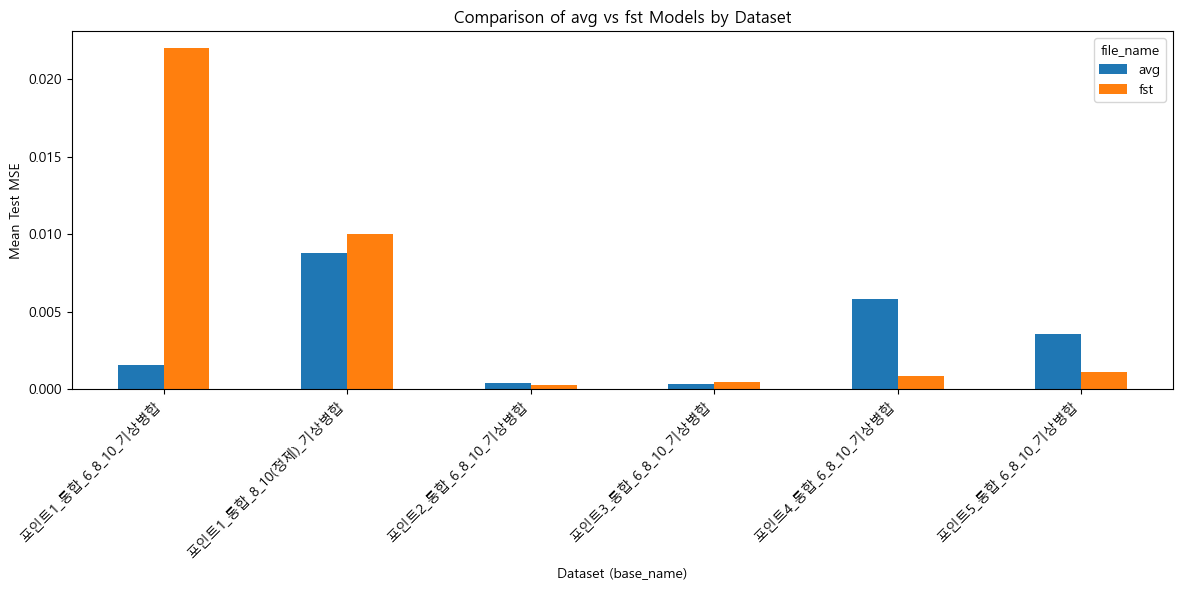

In [473]:
result_df['base_name'] = result_df['file_name'].str.replace(r'^(fst_|avg_)', '', regex=True)
print(result_df[['file_name', 'base_name']].head())

group_stats = result_df.groupby(['base_name', result_df['file_name'].str[:3]])['test_mse'].mean().unstack()
print(group_stats)

group_stats.plot(kind='bar', figsize=(12,6))
plt.title("Comparison of avg vs fst Models by Dataset")
plt.xlabel("Dataset (base_name)")
plt.ylabel("Mean Test MSE")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [474]:
vis_model = VanillaLSTM(input_size=10, hidden_size=32, num_layers=4, output_size=1)
print(vis_model)

VanillaLSTM(
  (lstm): LSTM(10, 32, num_layers=4, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)



🚀 Training on raw dataset...


  0%|          | 0/300 [00:00<?, ?it/s]

100%|██████████| 300/300 [00:07<00:00, 41.14it/s]


Saved: weights/20251103_155127_fst_포인트5_통합_6_8_10_기상병합_raw_3epoch.pth
✅ raw done | Epoch 3 | Test MSE: 0.009281

🚀 Training on interp dataset...


100%|██████████| 300/300 [00:37<00:00,  8.03it/s]


Saved: weights/20251103_155204_fst_포인트5_통합_6_8_10_기상병합_interp_280epoch.pth
✅ interp done | Epoch 280 | Test MSE: 0.021253
           datetime                       file_name best_epoch  \
79  20251103_155127     fst_포인트5_통합_6_8_10_기상병합_raw          3   
80  20251103_155204  fst_포인트5_통합_6_8_10_기상병합_interp        280   

               train_loss               val_loss             test_loss  \
79    0.28447168692946434   0.005655399989336729  0.009281238541007042   
80  0.0008535997319995658  0.0005107055476401001   0.02125321328639984   

       test_mse hidden_size num_layers  
79  0.009281239          64          2  
80  0.021253213          64          2  


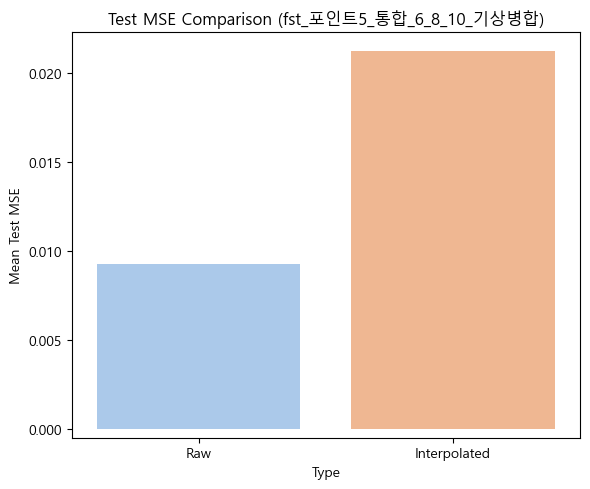

In [511]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

def train_and_evaluate(df, file_label, file_name):
    print(f"\n🚀 Training on {file_label} dataset...")

    df['날짜'] = pd.to_datetime(df['날짜'])
    df = df.sort_values('날짜')
    df.set_index('날짜', inplace=True)

    try:
        features = df.drop(columns=['날짜 시간', 'TM']).values
    except:
        features = df.drop(columns=['TM']).values

    scaler = MinMaxScaler()
    scaled_features = scaler.fit_transform(features)

    chl_flu_idx, chl_conc_idx = 16, 17
    seq_len = 5
    X, y = [], []
    for i in range(len(scaled_features) - seq_len):
        X.append(scaled_features[i:i+seq_len])
        next_day = scaled_features[i + seq_len]
        y.append(next_day[[chl_flu_idx, chl_conc_idx]])

    X, y = np.array(X), np.array(y)

    # 데이터 분할
    train_size = int(len(X) * 0.8)
    val_size = int(len(X) * 0.1)
    X_train, y_train = X[:train_size], y[:train_size]
    X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
    X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

    train_loader = DataLoader(TimeSeriesDataset(X_train, y_train), batch_size=8, shuffle=True)
    val_loader = DataLoader(TimeSeriesDataset(X_val, y_val), batch_size=8, shuffle=False)
    test_loader = DataLoader(TimeSeriesDataset(X_test, y_test), batch_size=8, shuffle=False)

    # 모델 설정
    input_size = X_train.shape[2]
    hidden_size = 64
    num_layers = 2
    output_size = 2

    model = VanillaLSTM(input_size, hidden_size, num_layers, output_size)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    num_epochs = 300
    best_val_loss = float('inf')
    best_train_loss = float('inf')
    best_epoch = 0

    for epoch in tqdm(range(num_epochs)):
        model.train()
        total_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_val, y_val in val_loader:
                preds = model(X_val)
                val_loss += criterion(preds, y_val).item()

        avg_train_loss = total_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_train_loss = avg_train_loss
            best_epoch = epoch + 1
            best_model_state = model.state_dict().copy()

    time_str = datetime.now().strftime("%Y%m%d_%H%M%S")
    weight_dir = "weights"
    weight_name = f"{time_str}_{file_name}_{file_label}_{best_epoch}epoch.pth"
    torch.save(model.state_dict(), f"{weight_dir}/{weight_name}")
    print(f"Saved: {weight_dir}/{weight_name}")

    model.load_state_dict(best_model_state)

    # 테스트
    model.eval()
    all_preds, all_labels = [], []
    total_samples, test_loss = 0, 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            preds = model(X_batch)
            loss = criterion(preds, y_batch).item()
            batch_size = X_batch.size(0)
            test_loss += loss * batch_size
            total_samples += batch_size
            all_preds.append(preds)
            all_labels.append(y_batch)

    test_loss /= total_samples
    y_pred = torch.cat(all_preds, dim=0).numpy()
    y_true = torch.cat(all_labels, dim=0).numpy()
    mse_each = ((y_pred - y_true) ** 2).mean(axis=0)

    # 로그 저장
    time_str = datetime.now().strftime("%Y%m%d_%H%M%S")
    df_new = pd.DataFrame([{
        "datetime": time_str,
        "file_name": f"{file_name}_{file_label}",
        "best_epoch": best_epoch,
        "train_loss": best_train_loss,
        "val_loss": best_val_loss,
        "test_loss": test_loss,
        "test_mse": np.mean(mse_each),
        "hidden_size": hidden_size,
        "num_layers": num_layers
    }])
    df_new.to_csv("weights/weights_result.csv", mode="a", index=False, header=False, encoding="utf-8-sig")

    print(f"✅ {file_label} done | Epoch {best_epoch} | Test MSE: {np.mean(mse_each):.6f}")
    return np.mean(mse_each)

file_name = "fst_포인트5_통합_6_8_10_기상병합"

df_raw = pd.read_csv(f"data/{file_name}.csv")
df_interp = pd.read_csv("data/data_interpolated.csv")

mse_raw = train_and_evaluate(df_raw, "raw", file_name)
mse_interp = train_and_evaluate(df_interp, "interp", file_name)

results = pd.read_csv("weights/weights_result.csv", names=[
    "datetime","file_name","best_epoch","train_loss","val_loss","test_loss","test_mse","hidden_size","num_layers"
])

subset = results[results["file_name"].str.contains(f"{file_name}_")].copy()
print(subset)
subset["Type"] = subset["file_name"].apply(lambda x: "Interpolated" if "interp" in x else "Raw")
subset["test_mse"] = subset["test_mse"].astype(float)

plt.figure(figsize=(6,5))
sns.barplot(data=subset, x="Type", y="test_mse", hue="Type", palette="pastel", legend=False)
plt.title(f"Test MSE Comparison ({file_name})")
plt.ylabel("Mean Test MSE")
plt.ylim(-0.0005, None)
plt.tight_layout()
plt.show()


✅ df_full shape: (37, 35)
✅ feature columns: ['날짜', 'Actual Conductivity (µS/cm) (1066342)', 'Specific Conductivity (µS/cm) (1066342)', '염도 (PSU) (1066342)', '저항력 (Ω⋅cm) (1066342)', '밀도 (g/cm³) (1066342)', '총 용존 고형물 (TDS) (ppt) (1066342)', 'pH (pH) (1057024)', 'pH mV (mV) (1057024)', 'ORP (mV) (1057024)', '온도 (°C) (1068851)', '압력 (psi) (1064654)', '깊이 (m) (1064654)', '표면 고도 (m) (1064654)', 'RDO 농도 (mg/L) (954526)', 'RDO 포화 (%Sat) (954526)', '산소분압 (Torr) (954526)', 'Chlorophyll-a Fluorescence (RFU) (945787)', 'Chlorophyll-a 농도 (µg/L) (945787)', '외부 전압 (V) (1068851)', '대기압 (mbar) (1049665)', '온도 (°C) (1049665)', '위도 (°)', '경도 (°)', 'TM', 'RN', 'RN_DAY_-3', 'RN_DAY_-2', 'RN_DAY_-1', 'RN_DAY', 'SD_DAY', 'SD_TOT', 'SI', 'CA', 'WS']
✅ df_full shape: (144, 34)
✅ feature columns: ['Actual Conductivity (µS/cm) (1066342)', 'Specific Conductivity (µS/cm) (1066342)', '염도 (PSU) (1066342)', '저항력 (Ω⋅cm) (1066342)', '밀도 (g/cm³) (1066342)', '총 용존 고형물 (TDS) (ppt) (1066342)', 'pH (pH) (1057024)', 'pH mV 

100%|██████████| 100/100 [00:09<00:00, 10.07it/s]


✅ Training done (val_loss=0.001483)
🎯 Evaluation on RAW data: Test MSE = 0.064465
inv_pred shape: (32, 2)
inv_pred
 [[ 16.76424199  52.70643102]
 [ 52.88118789  91.40055721]
 [ 73.67936242 107.96191603]
 [ 76.11689472 106.03766078]
 [ 78.90599184 108.60290825]]
inv_true shape: (32, 2)
inv_true
 [[ 90.56010266 123.47462297]
 [ 90.56010266 123.47462297]
 [ 77.12927405 104.89695886]
 [ 58.15686748  79.53148015]
 [ 77.12927405 104.89695886]]


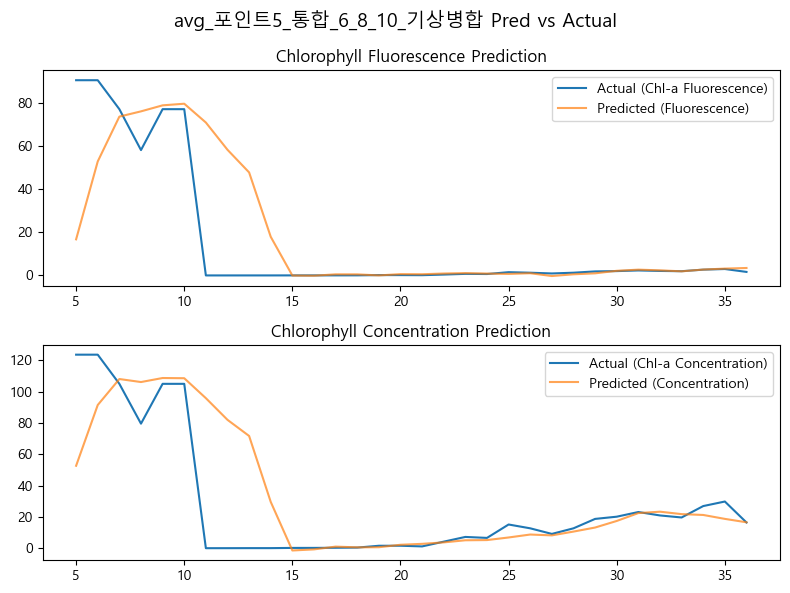

C:\Users\ty\AppData\Local\Temp\ipykernel_133560\483047909.py:136: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=["Fluorescence", "Concentration"], y=mse_each, palette="pastel")


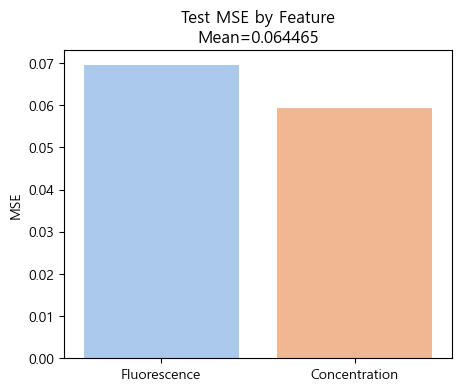

In [539]:
def train_model(df):
    df['날짜'] = pd.to_datetime(df['날짜'])
    df = df.sort_values('날짜').set_index('날짜')
    print("train_df shape:", df.shape)
    print("train feature columns:", df.columns.tolist())

    features = df[cols].values
    scaler = MinMaxScaler()
    scaled_features = scaler.fit_transform(df_full[cols].values)

    chl_flu_col = 'Chlorophyll-a Fluorescence (RFU) (945787)'
    chl_conc_col = 'Chlorophyll-a 농도 (µg/L) (945787)'
    chl_flu_idx = cols.index(chl_flu_col)
    chl_conc_idx = cols.index(chl_conc_col)
    print("chl_flu_idx:", chl_flu_idx, "chl_conc_idx:", chl_conc_idx)
    print("features:", features.shape)
    print(features[:3, [chl_flu_idx, chl_conc_idx]])

    seq_len = 5
    X, y = [], []
    for i in range(len(scaled_features) - seq_len):
        X.append(scaled_features[i:i+seq_len])
        next_day = scaled_features[i + seq_len]
        y.append(next_day[[chl_flu_idx, chl_conc_idx]])
    X, y = np.array(X), np.array(y)

    # Train/Val split
    train_size = int(len(X) * 0.9)
    X_train, y_train = X[:train_size], y[:train_size]
    X_val, y_val = X[train_size:], y[train_size:]

    train_loader = DataLoader(TimeSeriesDataset(X_train, y_train), batch_size=8, shuffle=True)
    val_loader = DataLoader(TimeSeriesDataset(X_val, y_val), batch_size=8, shuffle=False)

    input_size = X.shape[2]
    model = VanillaLSTM(input_size, 64, 2, 2)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    best_val = float('inf')
    for epoch in tqdm(range(100)):
        model.train()
        total_loss = 0
        for Xb, yb in train_loader:
            optimizer.zero_grad()
            loss = criterion(model(Xb), yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        model.eval()
        val_loss = np.mean([criterion(model(Xv), yv).item() for Xv, yv in val_loader])
        if val_loss < best_val:
            best_val = val_loss
            best_state = model.state_dict().copy()

    model.load_state_dict(best_state)
    print(f"✅ Training done (val_loss={best_val:.6f})")
    return model, scaler


def evaluate_model(model, df, scaler):
    df['날짜'] = pd.to_datetime(df['날짜'])
    df = df.sort_values('날짜').set_index('날짜')

    # print("eval df shape:", df.shape)
    # print("eval feature columns:", df.columns.tolist())

    features = df[cols].values
    scaled_features = scaler.transform(features)

    chl_flu_col = 'Chlorophyll-a Fluorescence (RFU) (945787)'
    chl_conc_col = 'Chlorophyll-a 농도 (µg/L) (945787)'
    chl_flu_idx = cols.index(chl_flu_col)
    chl_conc_idx = cols.index(chl_conc_col)
    
    seq_len = 5
    X_test, y_true = [], []
    for i in range(len(scaled_features) - seq_len):
        X_test.append(scaled_features[i:i+seq_len])
        next_day = scaled_features[i + seq_len]
        y_true.append(next_day[[chl_flu_idx, chl_conc_idx]])
    X_test, y_true = np.array(X_test), np.array(y_true)

    test_loader = DataLoader(TimeSeriesDataset(X_test, y_true), batch_size=8, shuffle=False)

    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for Xb, yb in test_loader:
            out = model(Xb)
            preds.append(out)
            trues.append(yb)
    y_pred = torch.cat(preds).numpy()
    y_true = torch.cat(trues).numpy()
    mse_each = ((y_pred - y_true) ** 2).mean(axis=0)
    mse_mean = np.mean(mse_each)
    print(f"🎯 Evaluation on RAW data: Test MSE = {mse_mean:.6f}")

    # 🔸 Inverse transform (for visualization)
    dummy = np.zeros((len(y_pred), len(cols)))
    dummy[:, chl_flu_idx] = y_pred[:, 0]
    dummy[:, chl_conc_idx] = y_pred[:, 1]
    inv_pred = scaler.inverse_transform(dummy)[:, [chl_flu_idx, chl_conc_idx]]

    dummy_true = np.zeros((len(y_true), len(cols)))
    dummy_true[:, chl_flu_idx] = y_true[:, 0]
    dummy_true[:, chl_conc_idx] = y_true[:, 1]
    inv_true = scaler.inverse_transform(dummy_true)[:, [chl_flu_idx, chl_conc_idx]]
    
    print("inv_pred shape:", inv_pred.shape)
    print("inv_pred\n", inv_pred[:5])
    print("inv_true shape:", inv_true.shape)
    print("inv_true\n", inv_true[:5])

    # 🔸 Plot results
    dates = df_raw.index[seq_len:]

    fig, axes = plt.subplots(2, 1, figsize=(8, 6))
    fig.suptitle(f"{file_name} Pred vs Actual", fontsize=14)  # 전체 제목 추가

    axes[0].plot(dates, inv_true[:, 0], label="Actual (Chl-a Fluorescence)")
    axes[0].plot(dates, inv_pred[:, 0], label="Predicted (Fluorescence)", alpha=0.7)
    axes[0].set_title("Chlorophyll Fluorescence Prediction")
    axes[0].legend()

    axes[1].plot(dates, inv_true[:, 1], label="Actual (Chl-a Concentration)")
    axes[1].plot(dates, inv_pred[:, 1], label="Predicted (Concentration)", alpha=0.7)
    axes[1].set_title("Chlorophyll Concentration Prediction")
    axes[1].legend()

    plt.tight_layout()
    plt.show()

    # 🔸 Barplot for MSE
    plt.figure(figsize=(5,4))
    sns.barplot(x=["Fluorescence", "Concentration"], y=mse_each, palette="pastel")
    plt.title(f"Test MSE by Feature\nMean={mse_mean:.6f}")
    plt.ylabel("MSE")
    plt.show()

    return mse_mean

cols = [c for c in df_raw.columns if c not in ['날짜','TM']]

file_name = "avg_포인트5_통합_6_8_10_기상병합"
df_raw = pd.read_csv(f"data/{file_name}.csv")

df_raw['날짜'] = pd.to_datetime(df_raw['날짜'])
df_raw = df_raw.sort_values('날짜')
print("✅ df_full shape:", df_raw.shape)
print("✅ feature columns:", df_raw.columns.tolist())

full_range = pd.date_range(start=df_raw['날짜'].min(), end=df_raw['날짜'].max(), freq='D')
df_full = df_raw.set_index('날짜').reindex(full_range).interpolate(method='linear')

df_full.index.name = '날짜'
df_full = df_full.interpolate(method='linear')
print("✅ df_full shape:", df_full.shape)
print("✅ feature columns:", df_full.columns.tolist())

df_full.to_csv("data/data_interpolated.csv", index=True, encoding='utf-8-sig')
print("✅ 'data_interpolated.csv' 파일이 생성되었습니다.")

df_interp = pd.read_csv("data/data_interpolated.csv")

model, scaler = train_model(df_interp)      # 보간 데이터로 학습
mse_real = evaluate_model(model, df_raw, scaler)  # 원본 데이터로 테스트
